In [ ]:
from numpy.random import choice
from scipy.stats import beta, norm
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### Sampling from a Hierarchical Dirichlet Process using Stochastic Memoization

Fully constructing a sample (a probability distribution) from a Dirichlet process would require drawing a countably infinite number of samples from $H_0$ and from the beta distribution to generate the weights. This would take forever.
We can use stochastic memoization to construct a distribution sampled from a Dirichlet process in a just-in-time manner, which allows us to draw samples from the distribution sampled from a Dirichlet process. The result can be considered as an empirical approximation of the sampled distribution.

Following the notation from the previous post, for example, if we have sampled a distribution $H$ from a Dirichlet process $DP (\alpha, H_0)$ :

$$w_1=0.5,\; w_2=0.3,\; \phi_1=0.1,\; \phi_2=-0.5.$$

Then, with probability $w_1 = 0.5$, our new sample is 0.1; with probability $w_2 = 0.3$, new sample is -0.5; with probability $1-w_1-w_2 = 0.2$, we draw a new sample from the base measure $H_0$, and draw $w_3$ at the same time.

This process provides us with the equivalent of the [Scipy `rvs`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html) method for the sampled distribution.  Stochastic memoization is equivalent to the [Chinese restaurant process](http://www.cs.princeton.edu/courses/archive/fall07/cos597C/scribe/20070921.pdf): sometimes you get seated an an occupied table (i.e. sometimes you're given a sample you've seen before) and sometimes you're put at a new table (given a unique sample). 

Here is the memoization class:


In [66]:
from numpy.random import choice

class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return choice(range(len(weights)), p=weights)
        else:
            return Nontyp

We still use standard Gaussian as the base measure, and generate samples from the Dirichlet process with varying $\alpha$.

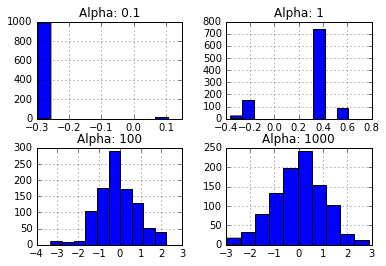

In [67]:
base_measure = lambda: norm().rvs()
draw_dp = {}
num_draw = 1000

for alpha in [.1, 1, 100, 1000]:
    dp = DirichletProcessSample(base_measure = base_measure, alpha = alpha) # class 
    draw_dp["Alpha: %s" % alpha] = [dp() for _ in range (num_draw)]  # draw samples from the sampled distribution
    
_ = pd.DataFrame(samples).hist()

Note that these histograms look very similar to the corresponding plots of sampled distributions in the previous notebook. However, these histograms are plotting points sampled from a distribution sampled from a Dirichlet process while the previous plots were showing approximate distributions samples from the Dirichlet process.

When sampling from the Dirichlet process directly, we do not need to take previous samples into account. However, if we sample from the sampled distribution from a Dirichlet process, the previous samples (sampled distribution) matter.

Of course, as the number of samples from each $H$ grows large, we would expect the histogram to be a very good empirical approximation of $H$.

We can use the samples drawn from a sampled distribution of a Dirichlet process  as the base measure of another Dirichlet process, which leads us to the hierarchical Dirichlet process.

In [86]:
num_draw = 1000

sampler_dp = DirichletProcessSample(base_measure = base_measure, alpha = 1000) 
draws_dp = [dp() for _ in range(num_draw)]

hdp = DirichletProcessSample(sampler_dp, alpha=1000)
draws_hdp = [hdp() for _ in range (num_draw)] 

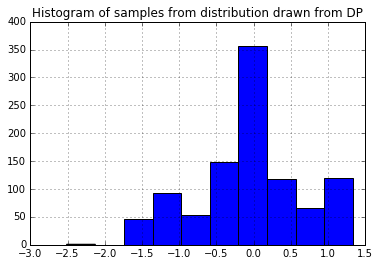

In [90]:
_ = pd.Series(draws_dp).hist()
_ = plt.title("Histogram of samples from distribution drawn from DP")

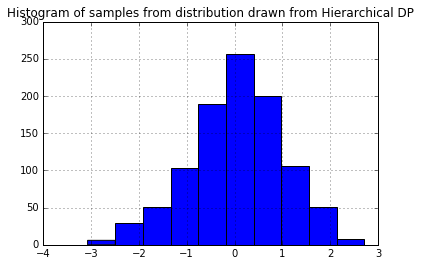

In [89]:
_ = pd.Series(draws_hdp).hist()
_=plt.title("Histogram of samples from distribution drawn from Hierarchical DP")

When $\alpha$ is larger, the sampled distribution or the samples from this distribution should be more similar to the base measure. Thus, the above two plots should be similar with a large $\alpha$.

`sampler_hdp` is not equivalent to the Hierarchical Dirichlet Process; it samples from a single distribution sampled from this HDP. Each time we instantiate the `sampler_hdp` variable, we are getting a sampler for a unique distribution.